# Feature engineering

## Импорт модулей и константы

In [1]:
import warnings


from catboost import CatBoostClassifier

from category_encoders.target_encoder import TargetEncoder

from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from pandas.plotting import scatter_matrix

import seaborn as sns

from scipy.stats import (percentileofscore,
                         randint,
                         ttest_ind,
                         uniform,
                        )

from sklearn.base import (BaseEstimator, 
                          TransformerMixin
                         )

from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import (GradientBoostingClassifier, 
                              RandomForestClassifier,
                              VotingClassifier,
                             )

from sklearn.feature_selection import (mutual_info_classif, 
                                       RFE,
                                       RFECV,
                                       SelectKBest,
                                      )

from sklearn.impute import (MissingIndicator, 
                            SimpleImputer,
                           )

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score,
                             f1_score,
                             get_scorer, 
                             roc_curve,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )

from sklearn.model_selection import (cross_val_predict, 
                                     cross_val_score,
                                     GridSearchCV,
                                     train_test_split,
                                    )

from sklearn.preprocessing import (Binarizer, 
                                   FunctionTransformer, 
                                   KBinsDiscretizer, 
                                   StandardScaler,
                                  )

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from xgboost import (plot_importance, 
                     XGBClassifier
                    )


from infographics import *


warnings.simplefilter(action='ignore', category=FutureWarning)


SEED = 42
CV = 5


%matplotlib inline

## Загрузка данных
Загрузим набор данных для разработки модели. Далее будем работать с этим набором данных.

In [2]:
data = pd.read_csv('../datasets/train.csv')

Загрузим набор признкаов для отправки результатов на проверку. Отложим этот набор.

In [3]:
submission_X = pd.read_csv('../datasets/test.csv')

## Разделения на тестовый и тренировочный наборы
Чтобы обучить модель и спрогнозировать точность её предсказаний на новых данных (результат соревнования) необходимо разделить данные (датафрейм `data`) на тестовый и тренировочный наборы. При разделении будем делать стратификацию по целевому признаку.

In [4]:
X = data.drop(columns = 'Survived')
y = data.Survived.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Обработка данных

### Разработка новых признаков

#### `Title`

In [5]:
def add_title(X, y=None):
    title = X.Name.str.extract(pat=r'\b,\s(.+?)\.\s[\b(]?')
    title = pd.Series(title[0], name='Title').str.lower()
    
    title = title.where(title.isin(['mr', 'miss', 'mrs', 'master']), 'aristocratic')
    
    return pd.concat([X, title], axis='columns')

TitleAdder = FunctionTransformer(func=add_title)

#### `AgeGroup` и `FareGroup`
```Python
Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
    ('encoder', TargetEncoder(cols=[0, 1])),
])
```

#### `Family`

In [6]:
def add_family(X, y=None):
    family = X.Parch + X.SibSp
    family.name ='Family'

    return pd.concat([X, family], axis='columns')

FamilyAdder = FunctionTransformer(func=add_family)

#### `isFramily`
Для добавления атрибута `isFramily` будем использовать `sklearn.preprocessing.Binarizer`.

#### `Cabin`

In [7]:
def encode_cabin(X, y=None):
    data = X.copy()
    data.Cabin = data.Cabin.str.slice(stop=1)
    data.loc[data.Cabin.isna(), 'Cabin'] = 'unknown'
    
    return data

CabinEncoder = FunctionTransformer(func=encode_cabin)

#### `Ticket`

In [8]:
def encode_ticket(X, y=None):
    data = X.copy()
    counts = data.Ticket.value_counts()
    data.Ticket = data.Ticket.replace(counts)
    
    data.loc[data.Ticket.isna(), 'Ticket'] = -1
    
    return data

TicketEncoder = FunctionTransformer(func=encode_ticket)

#### Отношения атрибутов

In [9]:
GetMax = FunctionTransformer(func=lambda X: X.max(axis=1)[:, np.newaxis])


def combine_fare_age(X, y=None):
    data = X.copy()
    data.loc[:, 'FareAgeComb'] = data.Fare / data.Age
    
    return data

CombFareAge = FunctionTransformer(func=combine_fare_age)


# preprocessed_data['pclass_vs_fareGroup'] = preprocessed_data.Pclass / preprocessed_data.FareGroup
def combine_fare_pclass(X, y=None):
    data = X.copy()
    data.loc[:, 'FarePclassComb'] = data.Fare / data.Pclass
    
    return data

CombFarePclass = FunctionTransformer(func=combine_fare_pclass)


def combine_sibsp_family(X, y=None):
    data = X.copy()
    data.loc[:, 'SibSpFamilyComb'] = data.SibSp / (data.Family + 1)
    
    return data


CombSibSpFamily = FunctionTransformer(func=combine_sibsp_family)


def combine_parch_family(X, y=None):
    data = X.copy()
    data.loc[:, 'ParchFamilyComb'] = data.Parch / (data.Family + 1)
    
    return data


CombParchFamily = FunctionTransformer(func=combine_parch_family)

### Оценка информативности признаков

#### Конвейер
Создадим конвейер, выполняющий обработку данных.

In [10]:
data_prep_target_enc = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    ('cabin_encoder', CabinEncoder),
    ('ticket_encoder', TicketEncoder),
    ('FareAgeComb', CombFareAge),
    ('FarePclassComb', CombFarePclass),
    ('SibSpFamilyComb', CombSibSpFamily),
    ('ParchFamilyComb', CombParchFamily),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name']),
        ('is_family', Binarizer(), ['Family']),
        ('title_sex_comb', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                   ('get_max', GetMax)
                  ]), 
         ['Sex', 'Title']
        ),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Sex', 'Embarked', 'Title', 'Cabin', 'Ticket']
        ),
        ('features_discr', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1, 2])),
         ]), 
         ['Age', 'Fare', 'FareAgeComb', 'FarePclassComb']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['Age', 'Fare', 'FareAgeComb', 'SibSp', 'Parch', 'Family', 'FarePclassComb', 'SibSpFamilyComb', 'ParchFamilyComb']
        ),
    ], remainder='passthrough')
    ),        
])

Попробуем обработать с помощью разработанного конвейера обучающую выборку, преобразовать результат в датафрейм и вывести его первые 5 строк.

In [11]:
cols = [
    'isFamily',
    'TitleSexComb',
    'Pclass', 
    'Sex', 
    'Embarked', 
    'Title', 
    'Cabin', 
    'Ticket',
    'AgeGroup', 
    'FareGroup', 'FareAgeCombGroup', 'FarePclassCombGroup', 'Age', 'Fare', 'FareAgeComb',
    'SibSp', 
    'Parch',
    'Family', 'FarePclassComb', 'SibSpFamilyComb', 'ParchFamilyComb',
]

preprocessed_data = pd.DataFrame(data_prep_target_enc.fit_transform(X=X_train, y=y_train), columns=cols)
preprocessed_data.head()

,isFamily,TitleSexComb,Pclass,Sex,Embarked,Title,Cabin,Ticket,AgeGroup,FareGroup,...,FarePclassCombGroup,Age,Fare,FareAgeComb,SibSp,Parch,Family,FarePclassComb,SibSpFamilyComb,ParchFamilyComb
0,0.0,0.185185,0.242967,0.185185,0.330116,0.152913,0.291667,0.416666,0.358025,0.603352,...,2.0,-0.081135,0.513812,-0.192552,-0.465084,-0.466183,-0.556339,-0.116956,-0.627576,-0.512903
1,0.0,0.185185,0.446667,0.185185,0.330116,0.152913,0.291667,0.317227,0.358025,0.236486,...,0.0,-0.081135,-0.662563,-0.192552,-0.465084,-0.466183,-0.556339,-0.497054,-0.627576,-0.512903
2,0.0,0.185185,0.649123,0.185185,0.330116,0.152913,0.682927,0.317227,0.358025,0.603352,...,3.0,-0.081135,3.955399,-0.192552,-0.465084,-0.466183,-0.556339,3.979279,-0.627576,-0.512903
3,1.0,0.785047,0.242967,0.743083,0.330116,0.785047,0.291667,0.317227,0.426829,0.252427,...,1.0,-0.887827,-0.467874,-0.197103,-0.465084,0.727782,0.073412,-0.434148,-0.627576,1.949439
4,1.0,0.785047,0.446667,0.743083,0.330116,0.785047,0.291667,0.623188,0.358025,0.435754,...,2.0,0.110934,-0.115977,-0.152221,0.478335,0.727782,0.703162,-0.232143,0.859100,1.128659


#### Корреляция между обучающими признаками

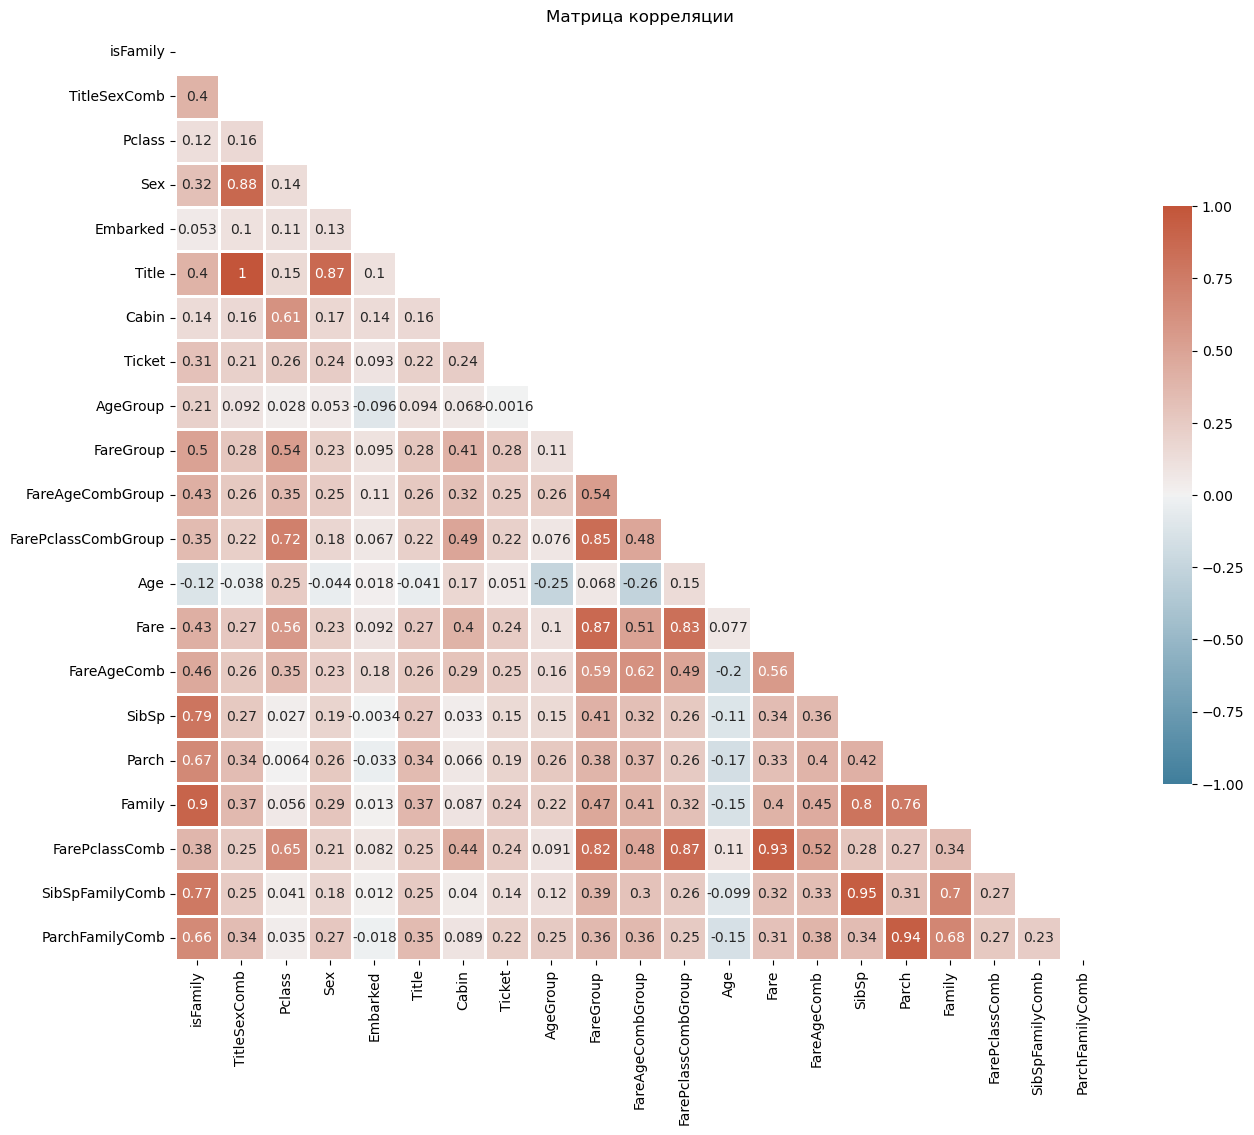

In [12]:
plot_corr_matrix(preprocessed_data, vmin=-1, vmax=1, size=(15, 15), method='kendall')

#### Взаимная информация (Mutual Information)

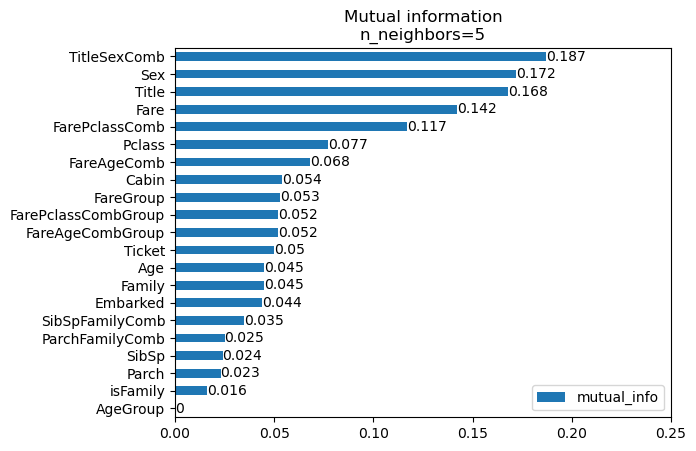

In [13]:
print_mi_scores(preprocessed_data, y_train, 5, random_state=SEED);

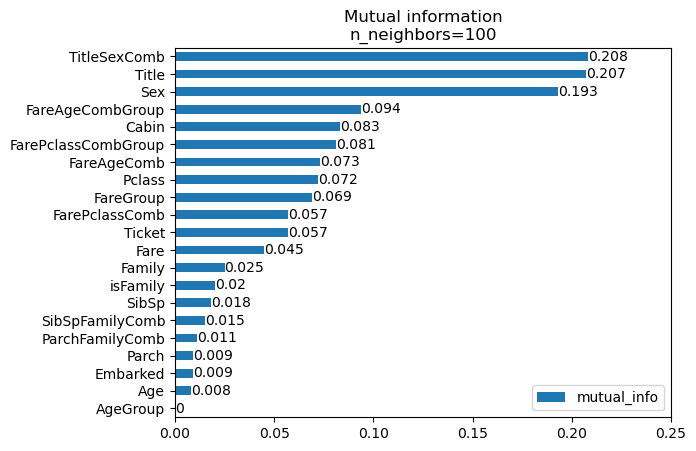

In [14]:
print_mi_scores(preprocessed_data, y_train, 100, random_state=SEED);

## Удаление скоррелированных признаков

,TitleSexComb,Pclass,Embarked,Cabin,Ticket,AgeGroup,FareGroup,FareAgeCombGroup,Age,FareAgeComb,Family,SibSpFamilyComb,ParchFamilyComb
0,0.185185,0.242967,0.330116,0.291667,0.416666,0.358025,0.603352,0.331984,-0.081135,-0.192552,-0.556339,-0.627576,-0.512903
1,0.185185,0.446667,0.330116,0.291667,0.317227,0.358025,0.236486,0.331984,-0.081135,-0.192552,-0.556339,-0.627576,-0.512903
2,0.185185,0.649123,0.330116,0.682927,0.317227,0.358025,0.603352,0.331984,-0.081135,-0.192552,-0.556339,-0.627576,-0.512903
3,0.785047,0.242967,0.330116,0.291667,0.317227,0.426829,0.252427,0.336364,-0.887827,-0.197103,0.073412,-0.627576,1.949439
4,0.785047,0.446667,0.330116,0.291667,0.623188,0.358025,0.435754,0.331984,0.110934,-0.152221,0.703162,0.859100,1.128659


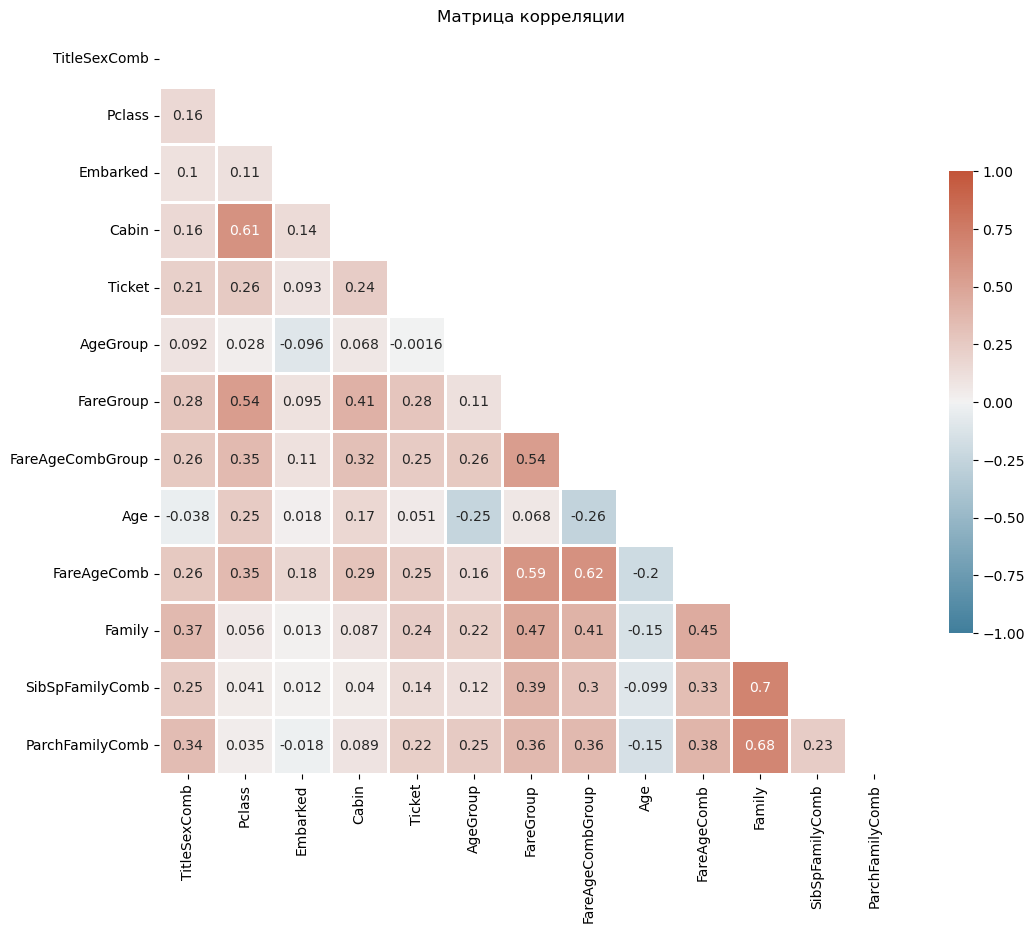

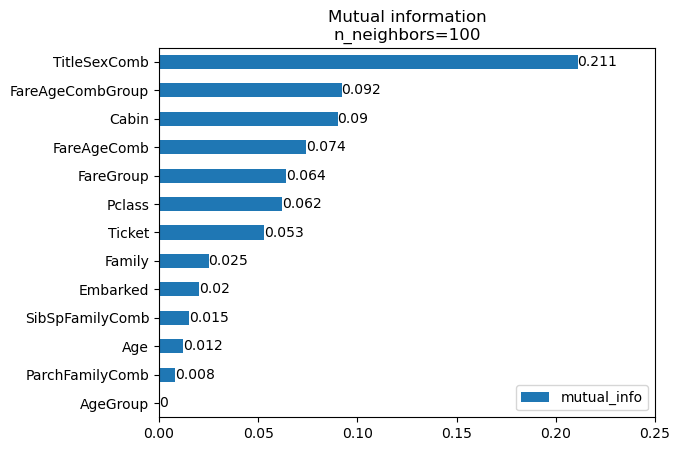

In [15]:
data_prep_target_enc = Pipeline([
    ('title_adder', TitleAdder),
    ('family_adder', FamilyAdder),
    ('cabin_encoder', CabinEncoder),
    ('ticket_encoder', TicketEncoder),
    ('FareAgeComb', CombFareAge),
    ('SibSpFamilyComb', CombSibSpFamily),
    ('ParchFamilyComb', CombParchFamily),
    
    ('col_selector', ColumnTransformer([
        ('drop', 'drop', ['PassengerId', 'Name']),
        ('title_sex_comb', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                   ('get_max', GetMax)
                  ]), 
         ['Sex', 'Title']
        ),
        ('cat_features', 
         Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', TargetEncoder()),
                  ]), 
         ['Pclass', 'Embarked', 'Cabin', 'Ticket']
        ),
        ('features_discr', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')),
             ('encoder', TargetEncoder(cols=[0, 1, 2])),
         ]), 
         ['Age', 'Fare', 'FareAgeComb']
        ),
        ('num_features', 
         Pipeline([
             ('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler()),
         ]), 
         ['Age', 'FareAgeComb', 'Family', 'SibSpFamilyComb', 'ParchFamilyComb']
        ),
    ], remainder='drop')
    ),        
])


cols = [
    'TitleSexComb',
    'Pclass', 
    'Embarked', 
    'Cabin', 
    'Ticket',
    'AgeGroup', 
    'FareGroup', 
    'FareAgeCombGroup', 
    'Age', 
    'FareAgeComb',
    'Family', 
    'SibSpFamilyComb', 
    'ParchFamilyComb',
]


preprocessed_data = pd.DataFrame(data_prep_target_enc.fit_transform(X=X_train, y=y_train), columns=cols)
display(preprocessed_data.head())


plot_corr_matrix(preprocessed_data, vmin=-1, vmax=1, size=(12, 12), method='kendall')


print_mi_scores(preprocessed_data, y_train, 100, random_state=SEED);